# Analysis of ascertainment strategies/biases

In [1]:
suppressPackageStartupMessages({

library(admixr)
library(tidyverse)

source("../R/utils.R")

})

In [2]:
samples <- load_samples()

Warning message:
“Missing column names filled in: 'X12' [12], 'X13' [13], 'X14' [14], 'X15' [15], 'X16' [16], 'X17' [17], 'X18' [18], 'X19' [19], 'X20' [20], 'X21' [21], 'X22' [22], 'X23' [23], 'X24' [24]”

## Calculate "direct" estimate of Nea. ancestry (on admixture array sites)

In [3]:
suppressMessages(
array_snps <- load_dataset("../clean_data/ice_age.tsv",
                           "../clean_data/sgdp.tsv",
                           "../clean_data/archaics.tsv",
                           filter_damage=TRUE,
                           random_sample=TRUE)
)

# list of samples with different library prep
non_udg_samples <- c("") #c("AfontovaGora3", "Kotias", "Oase1", "Satsurblia", "Villabruna")

direct_nea <- select(array_snps, -c(chrom, pos, ref, alt, contains("archaic"), one_of(non_udg_samples))) %>%
    summarise_all(function(ind) { mean(ind, na.rm=TRUE) / 2 }) %>%
    gather(name, alpha) %>%
    mutate(name=fix_name(name)) %>%
    group_by(name) %>%
    summarise(alpha=mean(alpha)) %>%
    mutate(method="direct")

Warning message:
“Unknown variables: ``”

In [4]:
snp_counts_direct <- select(array_snps, -c(chrom, pos, ref, alt, contains("archaic"), one_of(non_udg_samples))) %>%
    summarise_all(function(ind) { sum(!is.na(ind)) }) %>% 
    gather(name, snp_count) %>% 
    mutate(name=fix_name(name)) %>%
    group_by(name) %>%
    summarise(snp_count=as.integer(mean(snp_count)))

Warning message:
“Unknown variables: ``”

In [5]:
EIGENSTRAT_DIR <- "../raw_data/eigenstrat_all//"

EIGENSTRAT <- paste0(EIGENSTRAT_DIR, "UPA_merged_all")

SNP_FILE <- paste0(EIGENSTRAT_DIR, "UPA_merged_all.snp")
GENO_FILE <- paste0(EIGENSTRAT_DIR, "UPA_merged_all.geno")
IND_FILE <- paste0(EIGENSTRAT_DIR, "UPA_merged_all.ind")

BADSNP_FILE <- paste0(EIGENSTRAT_DIR, "UPA_merged_all.transitions.snp")

### Generate a table of SNPs to filter out (transitions)

In [6]:
read_fwf(SNP_FILE,
         fwf_widths(c(20, 6, 16, 16, 2, 2),
                    col_names=c("id", "chrom", "gen", "pos", "alt", "ref")),
         progress=FALSE) %>%
    keep_transitions %>%
    filter(chrom %in% 1:22) %>%
    write_tsv(BADSNP_FILE, col_names=FALSE)

Parsed with column specification:
cols(
  id = col_character(),
  chrom = col_integer(),
  gen = col_double(),
  pos = col_integer(),
  alt = col_character(),
  ref = col_character()
)


### Create a list of samples corresponding to David's Ice Age f4 ratio

In [7]:
merge_pops(IND_FILE, paste0(IND_FILE, ".IceAge"),
           merge=list(West_and_Central_Africans=c("Yoruba", "Mbuti", "Mende"),
                      Archaics=c("new_Altai", "new_Vindija")))

### Using all sites

In [8]:
all_iceage <- qpF4ratio(X=samples$name, A="West_and_Central_Africans", B="Archaics", C="Dinka", O="Chimp",
                           prefix=EIGENSTRAT,
                           ind=paste0(IND_FILE, ".IceAge")) %>% mutate(set="all", stat="african")
all_mbuti  <- qpF4ratio(X=samples$name, A="new_Altai", B="new_Vindija", C="Mbuti", O="Chimp", prefix=EIGENSTRAT) %>% mutate(set="all", stat="nea")
all_yoruba <- qpF4ratio(X=samples$name, A="new_Altai", B="new_Vindija", C="Yoruba", O="Chimp", prefix=EIGENSTRAT) %>% mutate(set="all", stat="nea")
all_dinka  <- qpF4ratio(X=samples$name, A="new_Altai", B="new_Vindija", C="Dinka", O="Chimp", prefix=EIGENSTRAT) %>% mutate(set="all", stat="nea")

### Using the big Yoruba sites only

In [9]:
EIGENSTRAT_BIG_YRI <- paste0(EIGENSTRAT, "_bigYRI")

In [10]:
subset_sites(prefix=EIGENSTRAT, out_prefix=EIGENSTRAT_BIG_YRI, bed_file="../raw_data/coordinates/big_yoruba.bed")

In [11]:
bigYRI_iceage <- qpF4ratio(X=samples$name, A="West_and_Central_Africans", B="Archaics", C="Dinka", O="Chimp",
                           prefix=EIGENSTRAT_BIG_YRI,
                           ind=paste0(IND_FILE, ".IceAge")) %>% mutate(set="bigYRI_both", stat="african")
bigYRI_mbuti  <- qpF4ratio(X=samples$name, A="new_Altai", B="new_Vindija", C="Mbuti", O="Chimp", prefix=EIGENSTRAT_BIG_YRI) %>% mutate(set="bigYRI_both", stat="nea")
bigYRI_yoruba <- qpF4ratio(X=samples$name, A="new_Altai", B="new_Vindija", C="Yoruba", O="Chimp", prefix=EIGENSTRAT_BIG_YRI) %>% mutate(set="bigYRI_both", stat="nea")
bigYRI_dinka  <- qpF4ratio(X=samples$name, A="new_Altai", B="new_Vindija", C="Dinka", O="Chimp", prefix=EIGENSTRAT_BIG_YRI) %>% mutate(set="bigYRI_both", stat="nea")

### Using the HO subset only

In [12]:
EIGENSTRAT_HO <- paste0(EIGENSTRAT, "_HO")

In [13]:
subset_sites(prefix=EIGENSTRAT,
             out_prefix=EIGENSTRAT_HO,
             bed_file="../raw_data/coordinates/big_yoruba.bed",
             complement=TRUE)

In [14]:
HO_iceage <- qpF4ratio(X=samples$name, A="West_and_Central_Africans", B="Archaics", C="Dinka", O="Chimp",
                       prefix=EIGENSTRAT_HO,
                       ind=paste0(IND_FILE, ".IceAge")) %>% mutate(set="HO", stat="african")
HO_mbuti  <- qpF4ratio(X=samples$name, A="new_Altai", B="new_Vindija", C="Mbuti", O="Chimp", prefix=EIGENSTRAT_HO) %>% mutate(set="HO", stat="nea")
HO_yoruba <- qpF4ratio(X=samples$name, A="new_Altai", B="new_Vindija", C="Yoruba", O="Chimp", prefix=EIGENSTRAT_HO) %>% mutate(set="HO", stat="nea")
HO_dinka  <- qpF4ratio(X=samples$name, A="new_Altai", B="new_Vindija", C="Dinka", O="Chimp", prefix=EIGENSTRAT_HO) %>% mutate(set="HO", stat="nea")

### Using random 1M subset

In [35]:
read_table2("../raw_data/coordinates/2.2M.bed", col_types="cii", col_names=c("chrom", "start", "end")) %>%
    sample_n(1e6) %>%
    write_tsv("../raw_data/coordinates/1M_subset.bed", col_names=FALSE)

In [36]:
EIGENSTRAT_RND <- paste0(EIGENSTRAT, "_RND")

In [37]:
subset_sites(prefix=EIGENSTRAT, out_prefix=EIGENSTRAT_RND, bed_file="../raw_data/coordinates/1M_subset.bed")

In [75]:
RND_iceage <- qpF4ratio(X=samples$name, A="West_and_Central_Africans", B="Archaics", C="Dinka", O="Chimp",
                       prefix=EIGENSTRAT_RND,
                       ind=paste0(IND_FILE, ".IceAge")) %>% mutate(set="random_1M_subset", stat="african")
RND_mbuti  <- qpF4ratio(X=samples$name, A="new_Altai", B="new_Vindija", C="Mbuti", O="Chimp", prefix=EIGENSTRAT_RND) %>% mutate(set="random_1M_subset", stat="nea")
RND_yoruba <- qpF4ratio(X=samples$name, A="new_Altai", B="new_Vindija", C="Yoruba", O="Chimp", prefix=EIGENSTRAT_RND) %>% mutate(set="random_1M_subset", stat="nea")
RND_dinka  <- qpF4ratio(X=samples$name, A="new_Altai", B="new_Vindija", C="Dinka", O="Chimp", prefix=EIGENSTRAT_RND) %>% mutate(set="random_1M_subset", stat="nea")

### Using a Yoruba or Altai subset of the Big Yoruba+Altai array

Load the GTs of Yoruba and Altai:

In [22]:
coord_dir <- "../raw_data/coordinates/"

In [19]:
suppressWarnings(suppressMessages(
    big_yoruba_gts <- read_table2("../raw_data/big_yoruba_and_altai_filtN_printed_probes_with_annotation.txt") %>%
    .[c(1, 2, 6, 9, 12)] %>%
    setNames(c("chrom", "pos", "gtY1", "gtY2", "gtNea"))
))

In [20]:
table(big_yoruba_gts$gtNea)
table(big_yoruba_gts$gtY1)
table(big_yoruba_gts$gtY2)


     -    0/1 
910967  86812 


     -    0/0    0/1    1/1 
 74746 300412 506173 116448 


     -    0/0    0/1    1/1 
 74746 324301 486683 112049 

In [23]:
filter(big_yoruba_gts, gtNea == "0/1") %>%
    mutate(start=as.integer(pos - 1), end=as.integer(pos)) %>%
    select(chrom, start, end) %>%
    write_tsv(file.path(coord_dir, "big_yoruba_Altai.bed"), col_names=FALSE)

filter(big_yoruba_gts, gtY1 == "0/1" | gtY2 == "0/1") %>%
    mutate(start=as.integer(pos - 1), end=as.integer(pos)) %>%
    select(chrom, start, end) %>%
    write_tsv(file.path(coord_dir, "big_yoruba_YRI.bed"), col_names=FALSE)

#### Yoruba subset:

In [24]:
EIGENSTRAT_BIG_YORUBA <- paste0(EIGENSTRAT_BIG_YRI, "_Yoruba")

In [25]:
subset_sites(prefix=EIGENSTRAT_BIG_YRI, out_prefix=EIGENSTRAT_BIG_YORUBA, bed_file="../raw_data/coordinates/big_yoruba_YRI.bed")

In [26]:
bigYoruba_iceage <- qpF4ratio(X=samples$name, A="West_and_Central_Africans", B="Archaics", C="Dinka", O="Chimp",
                           prefix=EIGENSTRAT_BIG_YORUBA,
                           ind=paste0(IND_FILE, ".IceAge")) %>% mutate(set="bigYRI_Yoruba", stat="african")
bigYoruba_mbuti  <- qpF4ratio(X=samples$name, A="new_Altai", B="new_Vindija", C="Mbuti", O="Chimp", prefix=EIGENSTRAT_BIG_YORUBA) %>% mutate(set="bigYRI_Yoruba", stat="nea")
bigYoruba_yoruba <- qpF4ratio(X=samples$name, A="new_Altai", B="new_Vindija", C="Yoruba", O="Chimp", prefix=EIGENSTRAT_BIG_YORUBA) %>% mutate(set="bigYRI_Yoruba", stat="nea")
bigYoruba_dinka  <- qpF4ratio(X=samples$name, A="new_Altai", B="new_Vindija", C="Dinka", O="Chimp", prefix=EIGENSTRAT_BIG_YORUBA) %>% mutate(set="bigYRI_Yoruba", stat="nea")

#### Altai subset:

In [27]:
EIGENSTRAT_ALTAI <- paste0(EIGENSTRAT_BIG_YRI, "_Altai")

In [28]:
subset_sites(prefix=EIGENSTRAT_BIG_YRI, out_prefix=EIGENSTRAT_ALTAI, bed_file="../raw_data/coordinates/big_yoruba_Altai.bed")

In [29]:
bigAltai_iceage <- qpF4ratio(X=samples$name, A="West_and_Central_Africans", B="Archaics", C="Dinka", O="Chimp",
                           prefix=EIGENSTRAT_ALTAI,
                           ind=paste0(IND_FILE, ".IceAge")) %>% mutate(set="bigYRI_Altai", stat="african")
bigAltai_mbuti  <- qpF4ratio(X=samples$name, A="new_Altai", B="new_Vindija", C="Mbuti", O="Chimp", prefix=EIGENSTRAT_ALTAI) %>% mutate(set="bigYRI_Altai", stat="nea")
bigAltai_yoruba <- qpF4ratio(X=samples$name, A="new_Altai", B="new_Vindija", C="Yoruba", O="Chimp", prefix=EIGENSTRAT_ALTAI) %>% mutate(set="bigYRI_Altai", stat="nea")
bigAltai_dinka  <- qpF4ratio(X=samples$name, A="new_Altai", B="new_Vindija", C="Dinka", O="Chimp", prefix=EIGENSTRAT_ALTAI) %>% mutate(set="bigYRI_Altai", stat="nea")

## Comparison between ascertainment strategies

In [76]:
all_res <- bind_rows(
    bind_rows(all_iceage, all_mbuti),
    bind_rows(bigYRI_iceage, bigYRI_mbuti),
    bind_rows(HO_iceage, HO_mbuti),
    bind_rows(RND_iceage, RND_mbuti),
    bind_rows(bigYoruba_iceage, bigYoruba_mbuti),
    bind_rows(bigAltai_iceage, bigAltai_mbuti)
) %>%
    select(-A, -B, -C, -O, -stderr, -setup) %>%
    inner_join(samples, by=c("X"="name"))

In [77]:
library(GGally)

my_line <- function(x,y,...){
    points(x,y,...)
    abline(a = 0,b = 1, lty=2)
}

compare_arrays <- function(df, s, p=NULL, Z=3, xlim=c(0, 0.06), ylim=c(0, 0.06), ...) {
    if (is.null(p)) p <- unique(all_res$pop)
    filter(df, abs(Zscore) > Z) %>%
    select(-Zscore) %>%
    filter(stat == s) %>%
    spread(set, alpha) %>%
    filter(pop %in% p) %>% 
    select(-X, -stat, -age, -pop) %>% 
    pairs(xlim=xlim, ylim=ylim, lower.panel = my_line, upper.panel = my_line, pch=20, ...)
#    { ggfacet(., aes(color=pop),
#              columnsX=c("all", "bigYRI", "HO"),
#              columnsY=c("all", "bigYRI", "HO"), fn="smooth_lm") +
#     coord_cartesian(xlim=c(0, 0.05), ylim=c(0, 0.05)) +
#     theme(legend.position="bottom")}
}

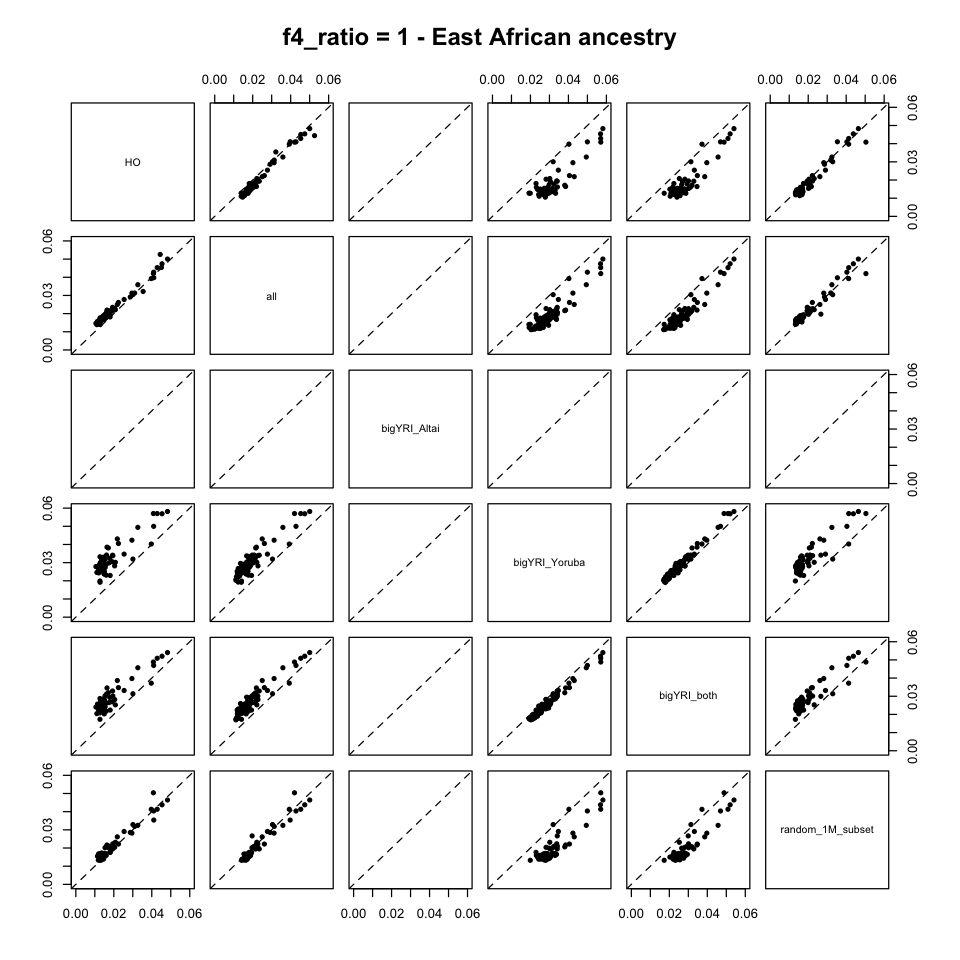

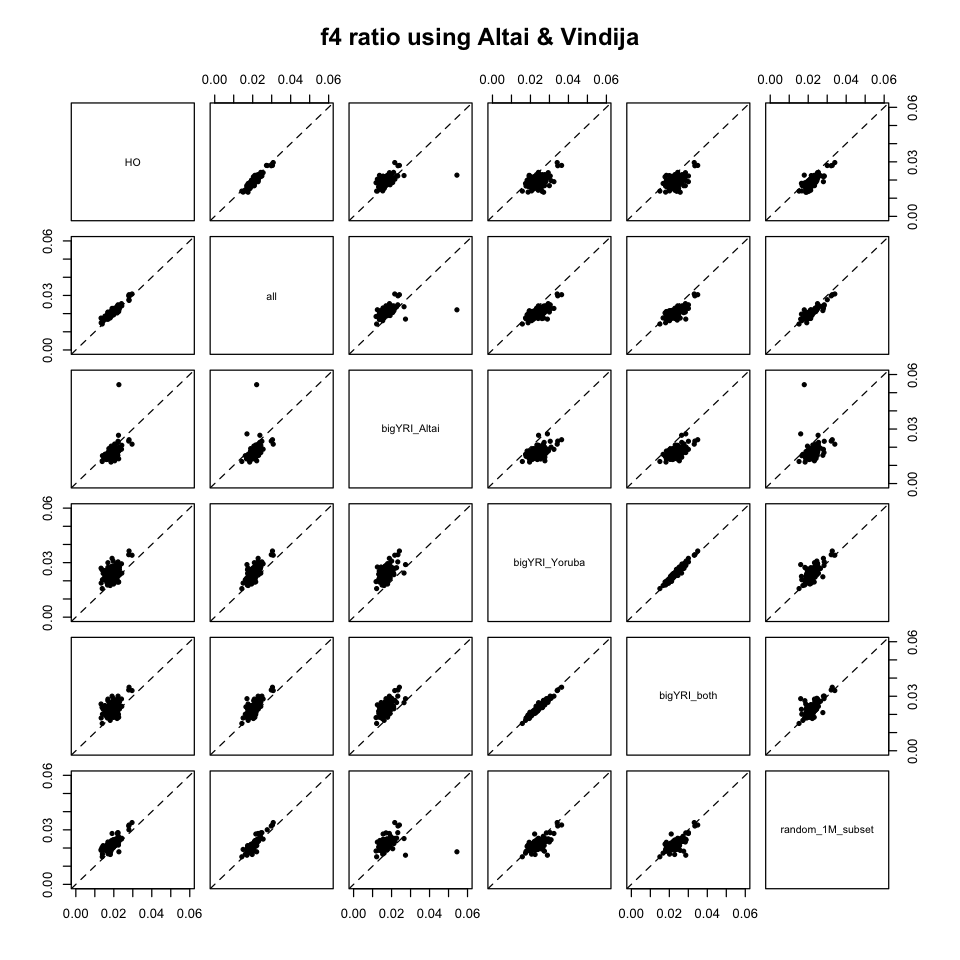

In [78]:
options(repr.plot.width=8, repr.plot.height=8)

all_res %>% compare_arrays("african", Z=3, main="f4_ratio = 1 - East African ancestry")
all_res %>% compare_arrays("nea", Z=3, main="f4 ratio using Altai & Vindija")

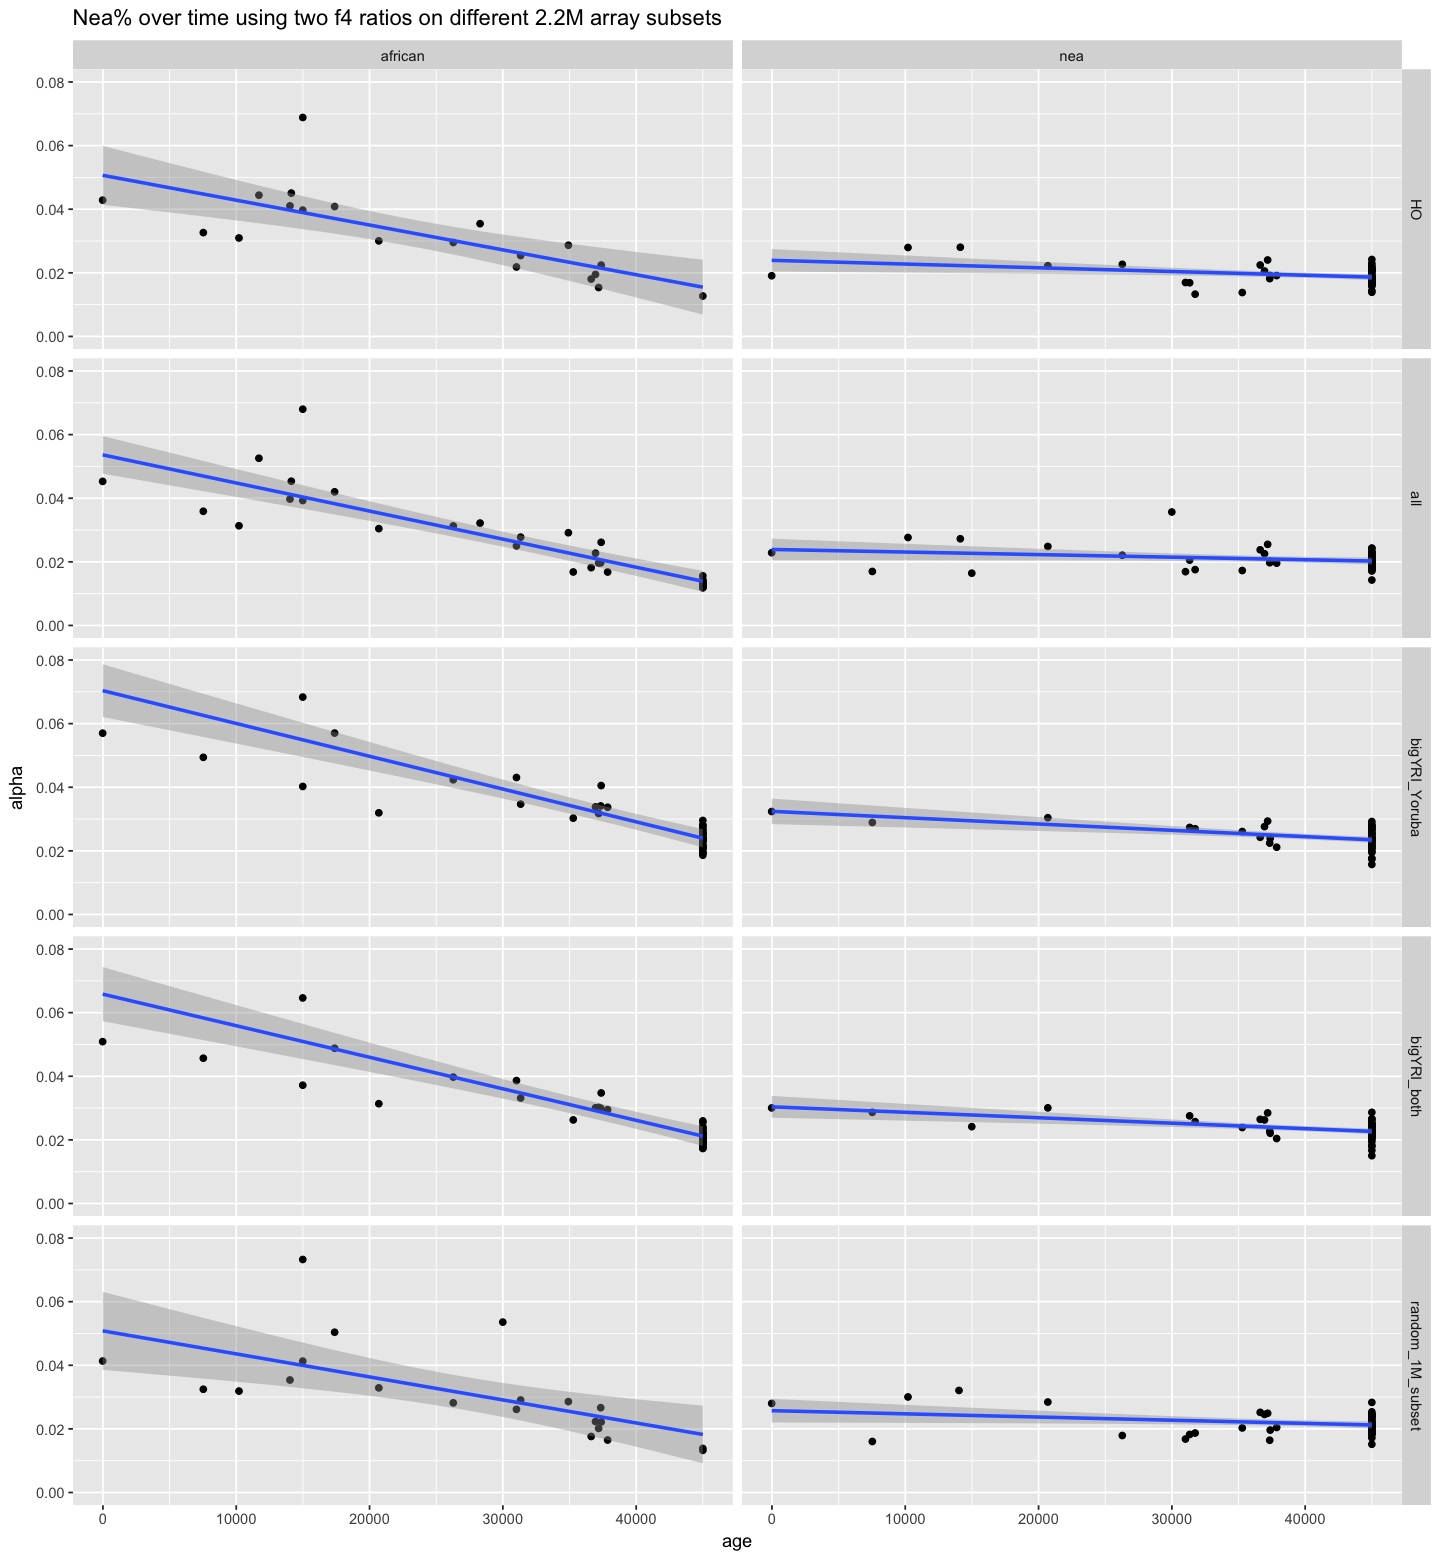

In [79]:
options(repr.plot.width=12, repr.plot.height=13)

filter(all_res, set != "bigYRI_Altai", abs(Zscore) > 3, pop %in% c("EMH", "WestEurasia")) %>% mutate(age=45000 - age) %>% 
ggplot(aes(age, alpha)) +
    geom_point() +
    geom_smooth(method="lm") +
    facet_grid(set ~ stat) +
    coord_cartesian(xlim=c(0, 45000), ylim=c(0, 0.08)) +
    ggtitle("Nea% over time using two f4 ratios on different 2.2M array subsets")

Joining, by = "name"


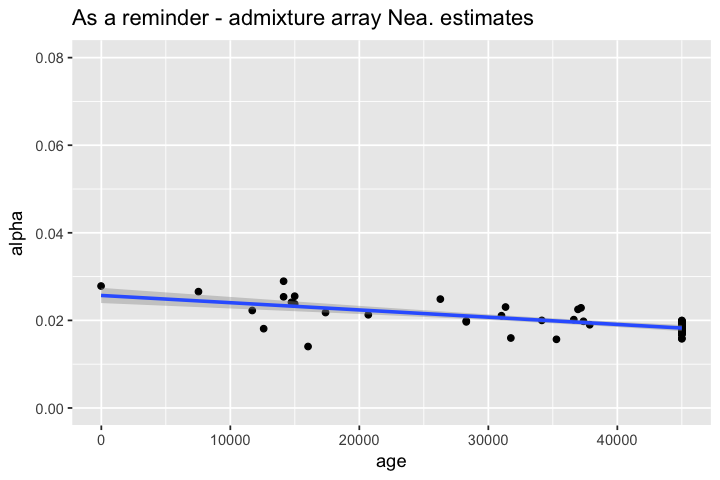

In [80]:
options(repr.plot.width=6, repr.plot.height=4)

inner_join(samples, direct_nea) %>% mutate(age=45000-age) %>% filter(pop %in% c("EMH", "WestEurasia")) %>% 
ggplot(aes(age, alpha)) +
    geom_point() +
    geom_smooth(method="lm") +
    coord_cartesian(xlim=c(0, 45000), ylim=c(0, 0.08)) +
    ggtitle("As a reminder - admixture array Nea. estimates")

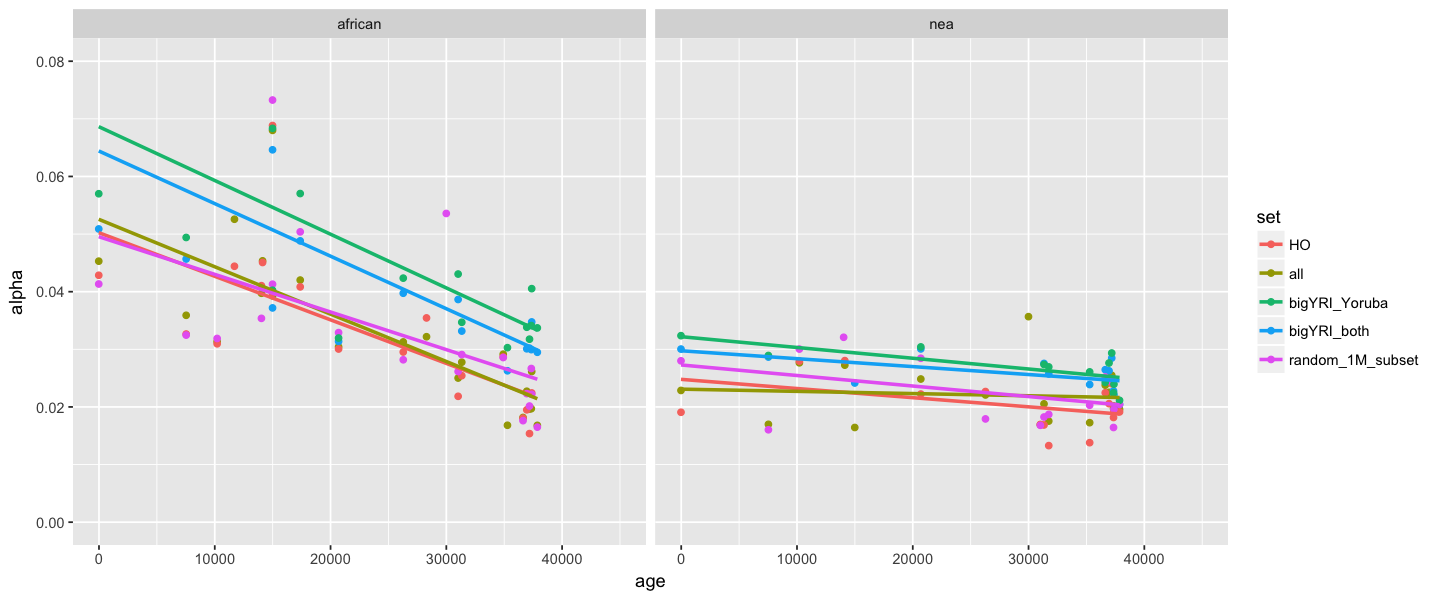

In [81]:
options(repr.plot.width=12, repr.plot.height=5)

filter(all_res, set != "bigYRI_Altai", age > 0, abs(Zscore) > 3, pop %in% c("EMH", "WestEurasia")) %>% mutate(age=45000 - age) %>% 
ggplot(aes(age, alpha, color=set)) +
    geom_point() +
    geom_smooth(method="lm", se=FALSE) +
    facet_grid(. ~ stat) +
    coord_cartesian(xlim=c(0, 45000), ylim=c(0, 0.08))

<br><br><br><br>
# Picking apart the Human Origins array

The idea here was to take the sets of SNPs ascertained in individual populations and check for potential biases in more details... However, since there doesn't seem that different subsets of 2.2M site array lead to different Nea-over-time patterns, the following analysis is not that interesting anymore.

Moreover, the number of SNPs ascertained in each panel is so low, that there are barely any informative ABBA/BABA sites. For example, a panel of 100k SNPs ascertained in a single French individual will contain only ~2% of sites shared with the Neanderthals and which are then informative (show the ABBA or BABA pattern). If we take then another French individual, he or she will have most likely a different 2% of the genome of Nea origin and so that H.O. panel will be barely informative about Nea. ancestry.

In [52]:
suppressWarnings(suppressMessages({

ho_snps <- read_table2("../raw_data/annotation.hg19.txt", comment="##") %>%
    .[c(ncol(.) - 2, ncol(.) - 1, ncol(.))] %>%
    setNames(c("chrom", "pos", "panel"))

ho_info <- read_table2("ascertainment sample_id panel snps
French          HGDP00521              1        111,970
Han             HGDP00778              2        78,253 
Papuan1         HGDP00542              3        48,531 
San             HGDP01029              4        163,313
Yoruba          HGDP00927              5        124,115
Mbuti           HGDP00456              6        12,162 
Karitiana       HGDP00998              7        2,635  
Sardinian       HGDP00665              8        12,922 
Melanesian      HGDP00491              9        14,988 
Cambodian       HGDP00711              10       16,987 
Mongolian       HGDP01224              11       10,757 
Papuan2         HGDP00551              12       12,117 
Denisova-San    Denisova-HGDP01029     13       151,435")

}))

In [53]:
table(ho_snps$panel)


     1      2      3      4      5      6      7      8      9     10     11 
117194  82163  51265 167504 128738  13094   2885  14261  16236  18358  11773 
    12     13 
 13098 155602 

In [54]:
ho_info

ascertainment,sample_id,panel,snps
French,HGDP00521,1,111970
Han,HGDP00778,2,78253
Papuan1,HGDP00542,3,48531
San,HGDP01029,4,163313
Yoruba,HGDP00927,5,124115
Mbuti,HGDP00456,6,12162
Karitiana,HGDP00998,7,2635
Sardinian,HGDP00665,8,12922
Melanesian,HGDP00491,9,14988
Cambodian,HGDP00711,10,16987


In [55]:
higher_cov <- c("French", "Han", "Papuan1", "San", "Yoruba")

In [56]:
coord_dir <- "../raw_data/coordinates/"

for (pop in ho_info$ascertainment) {
    panel_i <- filter(ho_info, ascertainment == pop)$panel
    
    filter(ho_snps, panel == panel_i) %>%
        arrange(chrom, pos) %>%
        filter(complete.cases(.)) %>%
        mutate(start=as.integer(pos - 1), end=as.integer(pos)) %>%
        select(chrom, start, end) %>%
        write_tsv(file.path(coord_dir, paste0("HO_", pop, ".bed")), col_names=FALSE)
}

In [57]:
for (pop in higher_cov) {
    bed_file <- file.path(coord_dir, paste0("HO_", pop, ".bed"))
    subset_sites(prefix=EIGENSTRAT, out_prefix=paste0(EIGENSTRAT, "_HO_", pop), bed_file=bed_file)
}

In [58]:
ho_res <- lapply(higher_cov, function(pop) {
    prefix <- paste0(EIGENSTRAT, "_HO_", pop)

    bind_rows(
        qpF4ratio(X=samples$name, A="West_and_Central_Africans", B="Archaics", C="Dinka", O="Chimp",
                  prefix=prefix, ind=paste0(IND_FILE, ".IceAge")) %>% mutate(stat="african"),
        qpF4ratio(X=samples$name, A="new_Altai", B="new_Vindija", C="Mbuti", O="Chimp", prefix=prefix) %>% mutate(stat="nea"),        
    ) %>% mutate(set=pop)
}) %>%
    bind_rows %>%
    select(-A, -B, -C, -O, -stderr, -setup) %>%
    inner_join(samples, by=c("X"="name"))

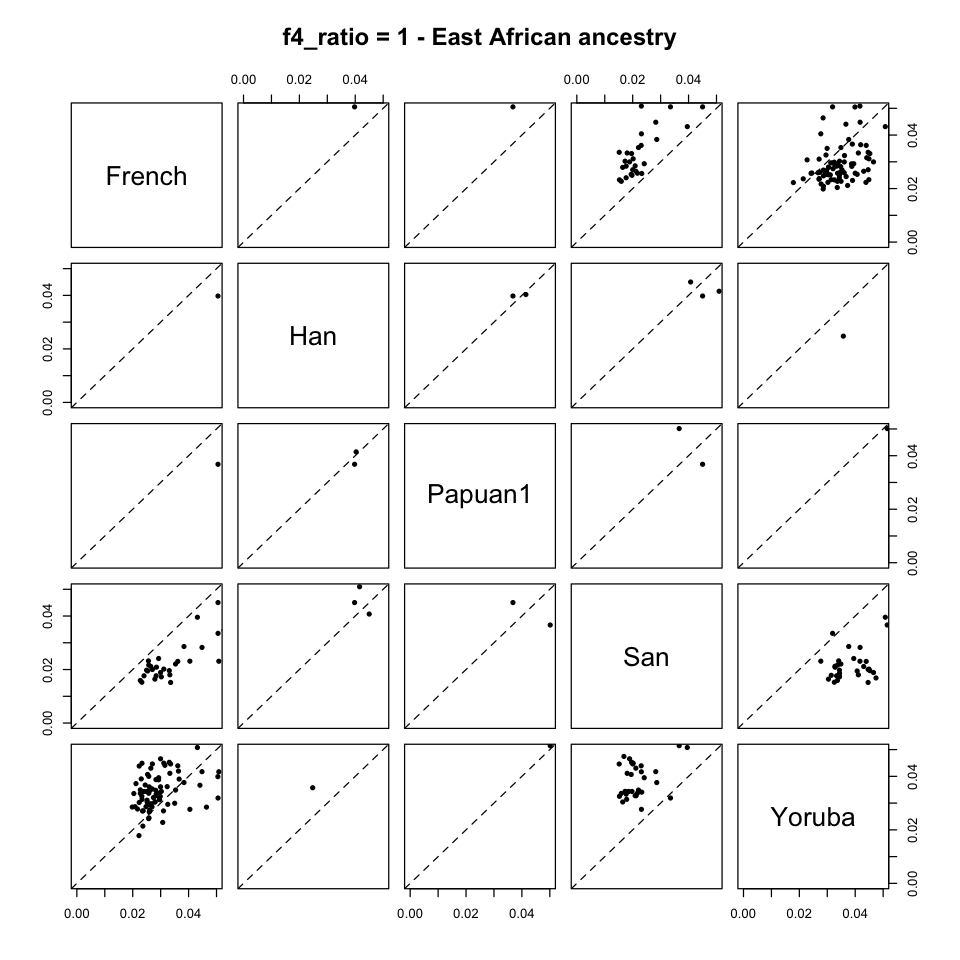

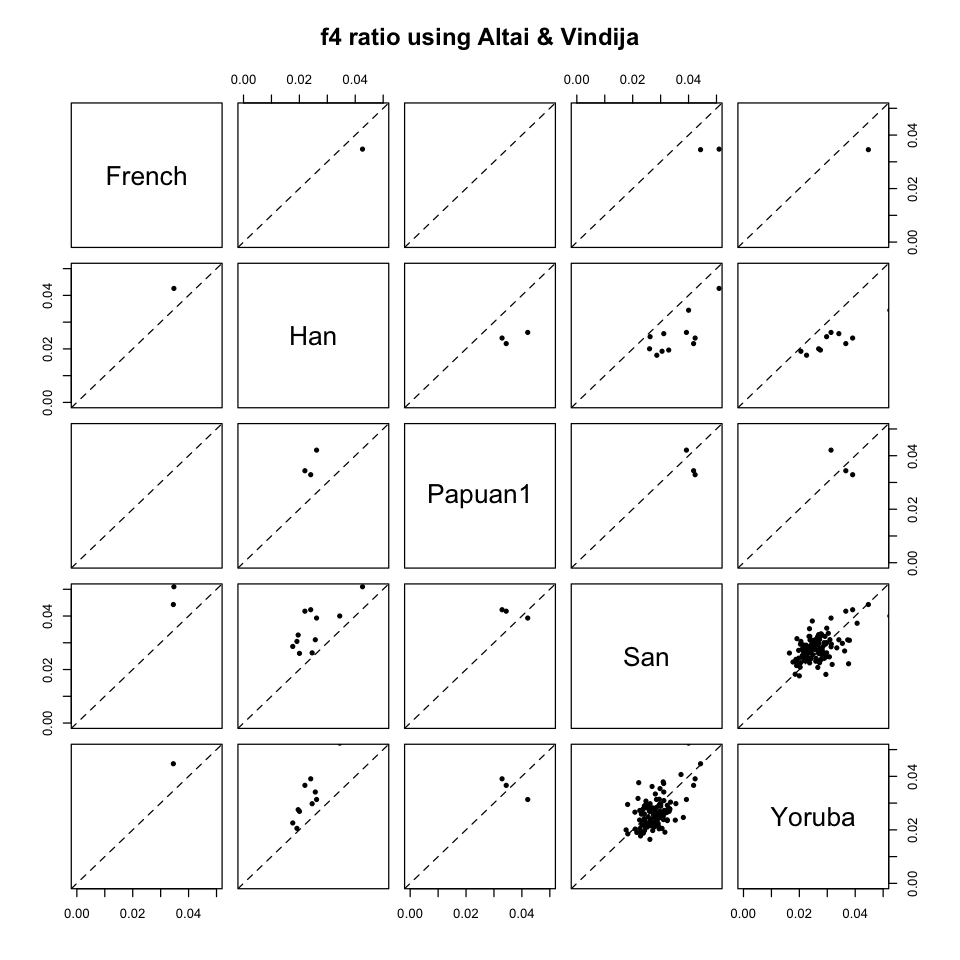

In [59]:
options(repr.plot.width=8, repr.plot.height=8)

ho_res %>% compare_arrays("african", Z=2, xlim=c(-0.0, 0.05), ylim=c(-0.0, 0.05), main="f4_ratio = 1 - East African ancestry")
ho_res %>% compare_arrays("nea", Z=2, xlim=c(-0.0, 0.05), ylim=c(-0.0, 0.05), main="f4 ratio using Altai & Vindija")

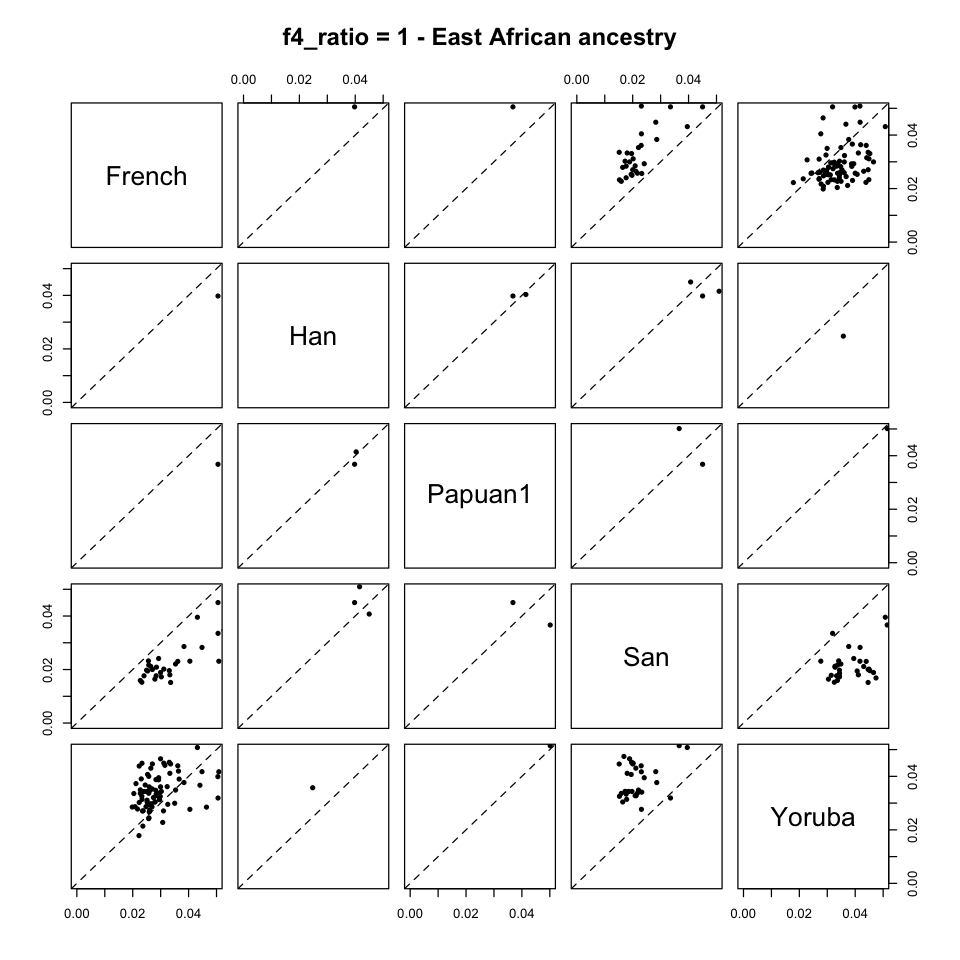

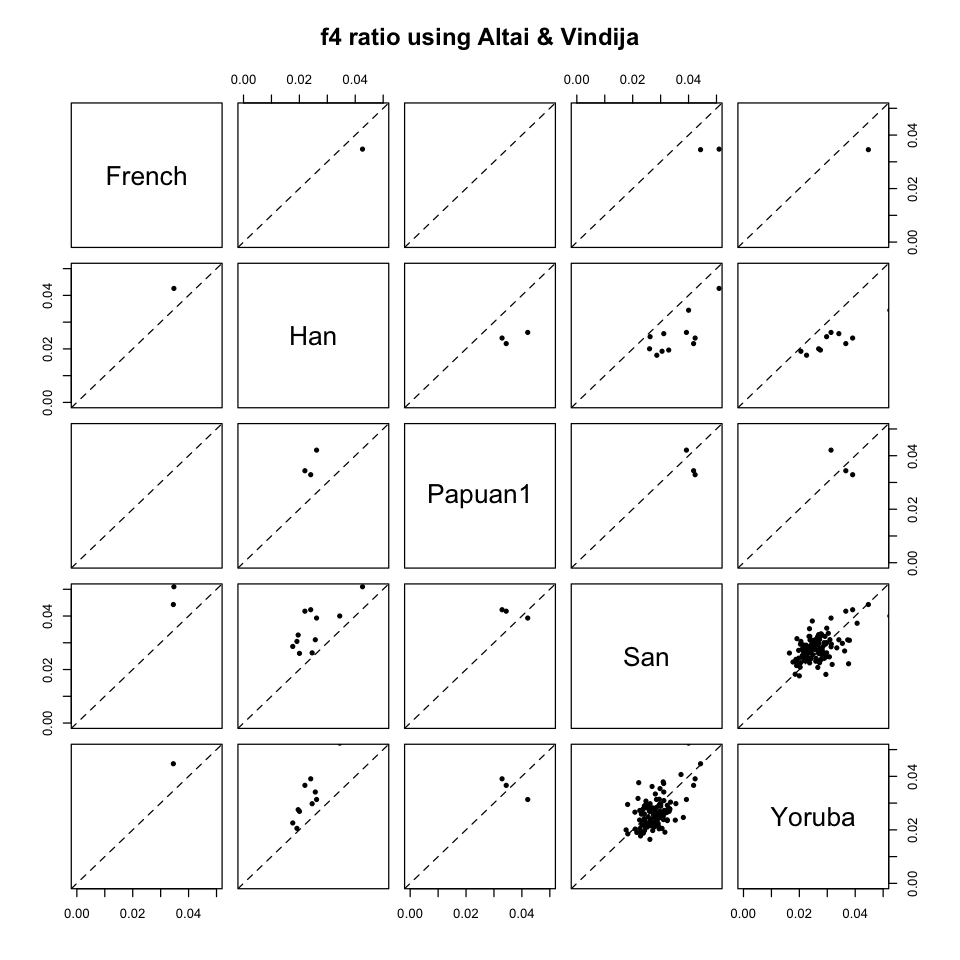

In [393]:
options(repr.plot.width=8, repr.plot.height=8)

ho_res %>% compare_arrays("african", Z=2, xlim=c(-0.0, 0.05), ylim=c(-0.0, 0.05), main="f4_ratio = 1 - East African ancestry")
ho_res %>% compare_arrays("nea", Z=2, xlim=c(-0.0, 0.05), ylim=c(-0.0, 0.05), main="f4 ratio using Altai & Vindija")

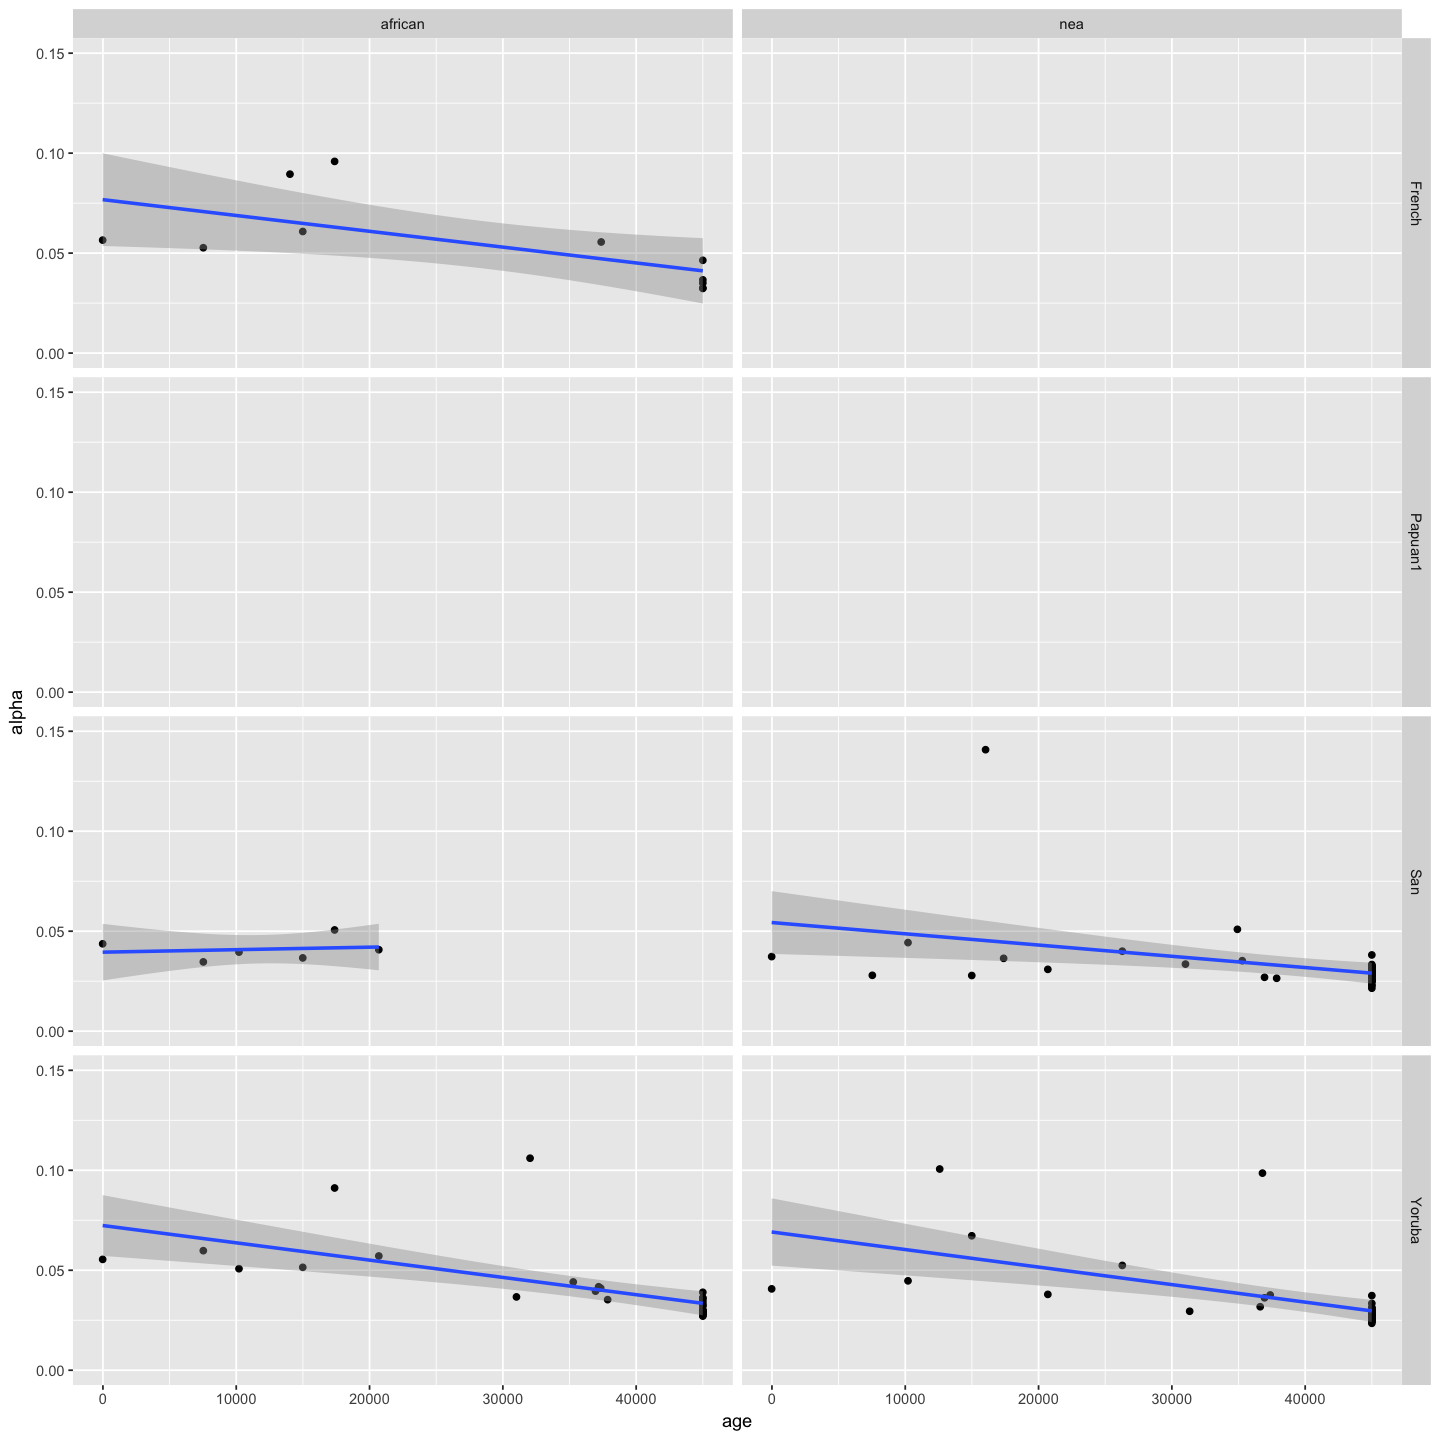

In [60]:
options(repr.plot.width=12, repr.plot.height=12)

ho_res %>% 
filter(abs(Zscore) > 3, pop %in% c("EMH", "WestEurasia")) %>% mutate(age=45000 - age) %>% 
ggplot(aes(age, alpha)) +
    geom_point() +
    geom_smooth(method="lm") +
    facet_grid(set ~ stat) +
    coord_cartesian(xlim=c(0, 45000), ylim=c(-0.0, 0.15))

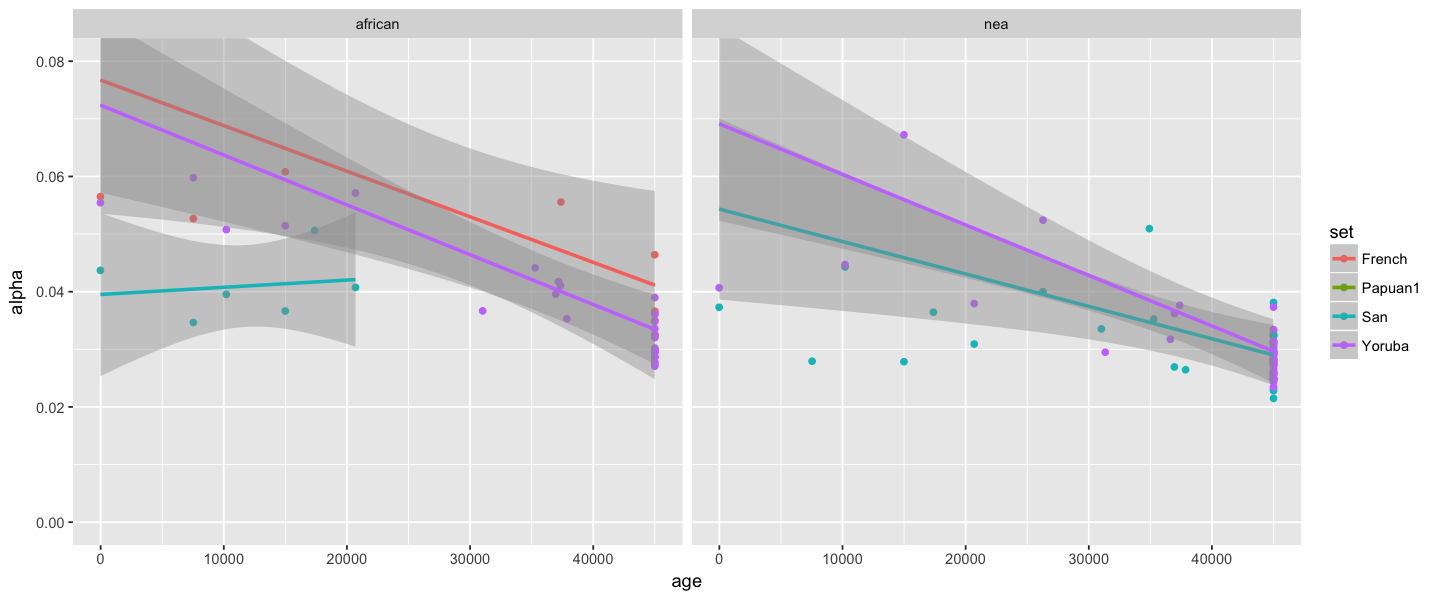

In [61]:
options(repr.plot.width=12, repr.plot.height=5)

ho_res %>% 
filter(abs(Zscore) > 3, pop %in% c("EMH", "WestEurasia")) %>% mutate(age=45000 - age) %>% 
ggplot(aes(age, alpha, color=set)) +
    geom_point() +
    geom_smooth(method="lm") +
    facet_grid(. ~ stat) +
    coord_cartesian(xlim=c(0, 45000), ylim=c(0, 0.08))

In [ ]:
ho_info

# TODO

### Run f3(European, EMH_X_individual, Mbuti)
### Run f4 with Vindija & Altai on the admixture array EIGENSTRAT data
### calculate f4 on the whole-genome SGDP data

In [62]:
save.image("../RData/admixtools_ascertainment.RData")